In [1]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
import os
import pickle
import scipy.io as spio
import mat73
import seaborn as sns

In [2]:
%matplotlib widget

- LFP
- position linearized
- 53 neurons
-> spikes align to position (neuron to position)

250 ms decoding trajecroty 
15-20 ms small departures (replay when stationary)

bayesian decoding on position 
take examples of replay and run model 

In [3]:
path = '../data/'

In [4]:
data = mat73.loadmat(path+'Data4Pset.mat')

In [5]:
ripple_data = spio.loadmat(path+'ripples.mat')

In [6]:
decode = spio.loadmat(path+'decodedPosition15ms.mat')

In [7]:
ripple_data['rip'].shape[0]

115

In [8]:
len(np.arange(0,115,1))

115

In [9]:
data.keys()

dict_keys(['SpikeTimes', 'lfp', 'pos'])

In [10]:
len(data['SpikeTimes'])

53

In [10]:
data['pos']

{'data': array([0.29185399, 0.29089648, 0.28777555, ...,        nan,        nan,
               nan]),
 'timestamp': array([6199.        , 6199.03333333, 6199.06666667, ..., 7047.9       ,
        7047.93333333, 7047.96666667]),
 'units': 'meters'}

In [11]:
data['pos']['data'].max()

nan

In [10]:
data['pos']['timestamp'].shape

(25470,)

In [22]:
def get_kernel(sigma, dt):
    s=np.arange(-3*sigma,3*sigma+dt,dt)
    k=np.exp(-(s**2)/(2*sigma**2))
    # Normalize
    k=k/sum(k)
    return k

In [23]:
def calc_spiketrain(spike_data, bins):
    return np.array([np.histogram(spike_times, bins=bins)[0] for spike_times in spike_data])

In [24]:
def plot_raw_data(ind_start = 0, ind_end = -1, return_data=False):
    fig, ax = plt.subplots(4,1, figsize=(15, 10), sharex=True)
    
    pos_time_data = data['pos']['timestamp'][ind_start:ind_end]
    pos_data = data['pos']['data'][ind_start:ind_end]

    ax[0].plot(pos_time_data,pos_data)
    #ind_sp = np.where(data['pos']['timestamp']==data['SpikeTimes'][cell])
    #ax[0].plot(data['SpikeTimes'][cell], data['pos']['data'][ind_start:ind_end])

    ax[0].set_ylabel('pos [m]')

    spike_data = []
    for i, st in enumerate(data['SpikeTimes']):
        ind_s = np.searchsorted(st, data['pos']['timestamp'][ind_start])
        ind_e = np.searchsorted(st, data['pos']['timestamp'][ind_end])
        if ind_e:
            ind_e=ind_e-1
        spike_data.append(st[ind_s:ind_e])
        ax[1].vlines(st[ind_s:ind_e], i, i+1, color='k')
    ax[1].set_ylabel('# neuron')

    ind_s = np.searchsorted(data['lfp']['timestamp'], data['pos']['timestamp'][ind_start])
    ind_e = np.searchsorted(data['lfp']['timestamp'], data['pos']['timestamp'][ind_end])
    ax[2].plot(data['lfp']['timestamp'][ind_s:ind_e], data['lfp']['data'][ind_s:ind_e])
    ax[2].set_ylabel('LFP [mV]')
    
    spike_time_data = data['lfp']['timestamp'][ind_s:ind_e]
    
    spike_trains = calc_spiketrain(spike_data, spike_time_data)
    spike_counts = np.sum(spike_trains, axis=0)
    spike_rate = np.sum(spike_trains, axis=0)/np.diff(spike_time_data)
    kernel = get_kernel(0.01, np.diff(spike_time_data)[0])
    print('dt= ', np.diff(spike_time_data)[0])
    SmoothedRate=np.convolve(kernel, spike_rate,'same')
    
    plt.plot(spike_time_data[:-1], SmoothedRate)
    ax[3].set_ylabel('rate [Hz]')
    ax[3].set_xlabel('time [s]')
    
    sns.despine()
    
    if return_data:
        return pos_time_data, spike_time_data, pos_data, spike_data, SmoothedRate

In [25]:
def boolean_to_times(boolean_array, times):
    """Given a boolean array and an array of times, extract start and end times of where
    boolean_array = True
    """
    start_times = []
    end_times = []
    previous_val = boolean_array[0]
    if previous_val:
        start_times.append(times[0])
    for count, val in enumerate(boolean_array[1:]):
        i = count + 1
        if val != previous_val:
            if val:
                start_times.append(times[i])
            else:
                end_times.append(times[i])
        previous_val = val
    if val:
        end_times.append(times[-1])
    return np.array(start_times), np.array(end_times)

In [26]:
def calc_binned_data(pos_time, pos, spikes_run, binsize=0.2, binsize_pos = 0.2):
    
    time_bin = np.arange(pos_time[0], pos_time[-1], binsize)
    pos_bin_ = np.arange(np.nanmin(pos), np.nanmax(pos_all), binsize_pos)
    
    pos_bin = []
    for i in range(len(time_bin)-1):
        m = np.mean(pos[np.where((pos_time>time_bin[i]) & (pos_time<time_bin[i+1]))[0]])
        pos_bin.append(m)
    last_m = np.mean(pos[np.where((pos_time>time_bin[-1]) & (pos_time<pos_time[-1]))[0]])
    pos_bin.append(last_m)
        
    spike_bin = []
    time_bin_ = np.append(time_bin,pos_time[-1]) 
    for sp in spikes_run:
        s = np.histogram(sp, bins=time_bin_)[0]
        spike_bin.append(s)
    
    return time_bin, np.array(pos_bin), np.array(spike_bin)

dt=  0.000499211038913927


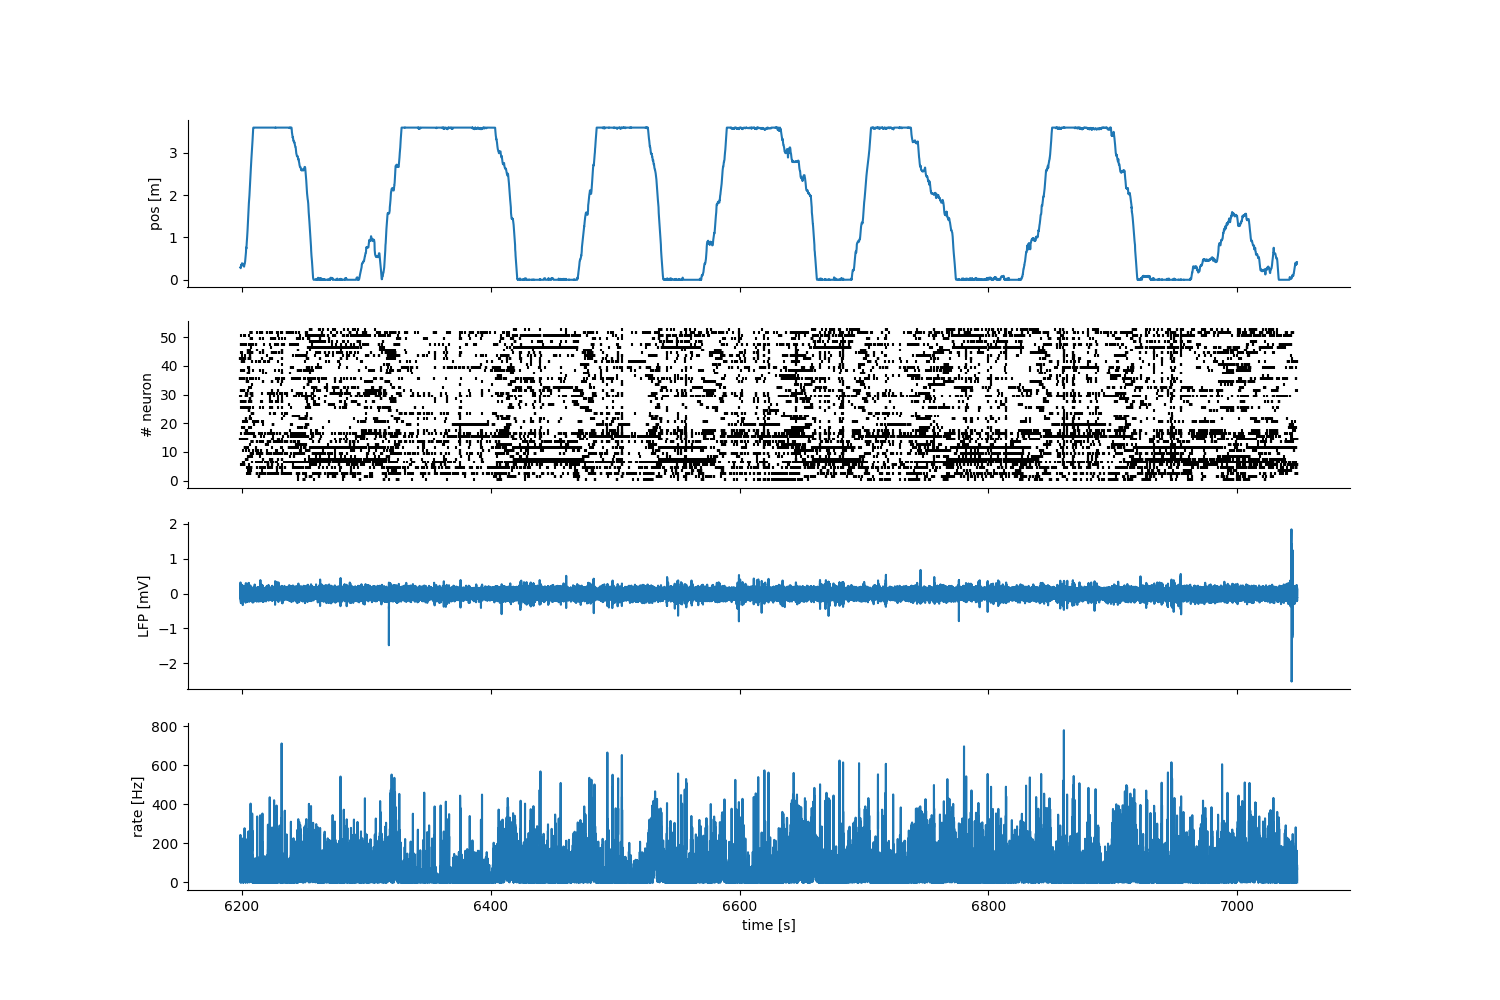

In [27]:
pos_time_all, spike_time_all, pos_all, spikes_all, firing_rate_all = plot_raw_data(return_data=True)

In [19]:
if np.any(np.isnan(firing_rate_all)):
    spike_time_all = spike_time_all[~np.isnan(firing_rate_all)]
    firing_rate_all = firing_rate_all[~np.isnan(firing_rate_all)]
ripple_boolean = firing_rate_all > 350
ripple_starts, ripple_ends = boolean_to_times(ripple_boolean, spike_time_all)

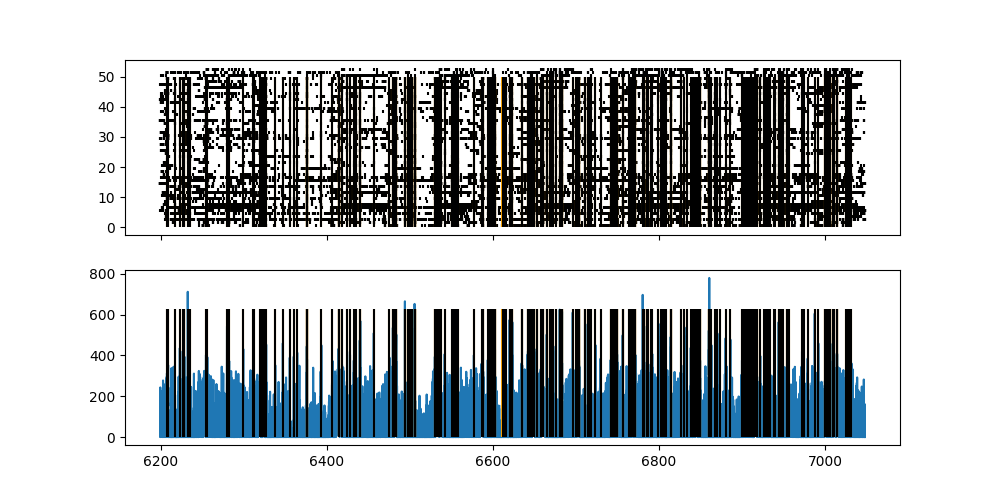

In [20]:
fig, ax = plt.subplots(2,1, figsize=(10,5), sharex=True)
for i, st in enumerate(spikes_all):
    ax[0].vlines(st, i, i+1, color='k')
ax[0].vlines(ripple_starts, 0, 50, 'orange')
ax[0].vlines(ripple_ends, 0, 50, 'black')
    
ax[1].plot(spike_time_all[:-1],firing_rate_all)
ax[1].vlines(ripple_starts, 0, np.nanmax(firing_rate_all)-150, 'orange')
ax[1].vlines(ripple_ends, 0, np.nanmax(firing_rate_all)-150, 'black')

In [21]:
pos_cm = pos_all*100

In [22]:
pos1 = pos_time_all[:-1]

In [23]:
pos2 = pos_time_all[1:]

In [24]:
velocity_times = (pos1 + pos2) / 2

In [25]:
pos_diff = np.diff(pos_cm)

In [26]:
velocity = pos_diff / np.diff(pos_time_all)

In [27]:
if np.any(np.isnan(velocity)):
    vel_times = velocity_times[~np.isnan(velocity)]
    velocity_ = velocity[~np.isnan(velocity)]
run_boolean = velocity_ > 15
run_boolean_back = velocity_ < -15
run_starts, run_ends = boolean_to_times(run_boolean, vel_times)
run_starts_back, run_ends_back = boolean_to_times(run_boolean_back, vel_times)

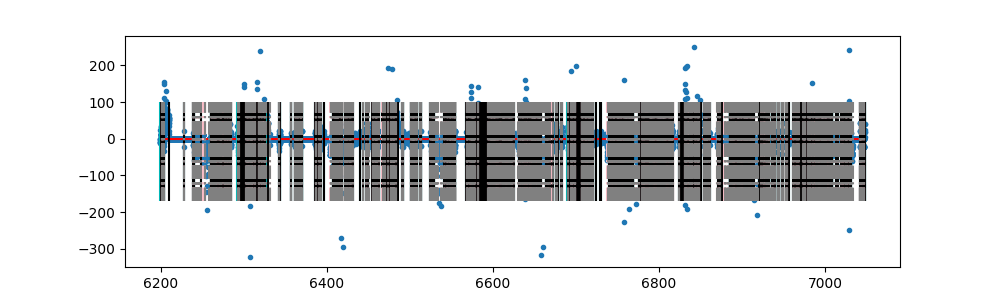

In [28]:
fig, ax = plt.subplots(1,1, figsize=(10,3))
ax.plot(velocity_times,velocity, '.')
ax.hlines(0, pos_time_all[0], pos_time_all[-1], 'r')
ax.vlines(run_starts, np.nanmin(velocity)+150, np.nanmax(velocity)-150, 'c', '-')
ax.vlines(run_ends, np.nanmin(velocity)+150, np.nanmax(velocity)-150, 'black', '-')

ax.vlines(run_starts_back, np.nanmin(velocity)+150, np.nanmax(velocity)-150, 'pink', '-.')
ax.vlines(run_ends_back, np.nanmin(velocity)+150, np.nanmax(velocity)-150, 'grey', '-.')

In [29]:
run_starts, run_ends

(array([6199.31666667, 6200.98333333, 6202.05      , ..., 7047.35      ,
        7047.61666667, 7047.78333333]),
 array([6199.51666667, 6201.01666667, 6202.28333333, ..., 7047.38333333,
        7047.75      , 7047.78333333]))

In [176]:
spike_all_flat = np.array([element for sublist in spikes_all for element in sublist])
spike_all_flat_ids = [np.full_like(cell, i) for i,cell in enumerate(spikes_all)]
spike_all_flat_ids_flat = np.array([element for sublist in spike_all_flat_ids for element in sublist])

In [177]:
spike_times_sorted = sorted(spike_all_flat)
spike_ids_sorted = [x for _, x in sorted(zip(spike_all_flat, spike_all_flat_ids_flat))]

## run

dt=  0.000499211038913927


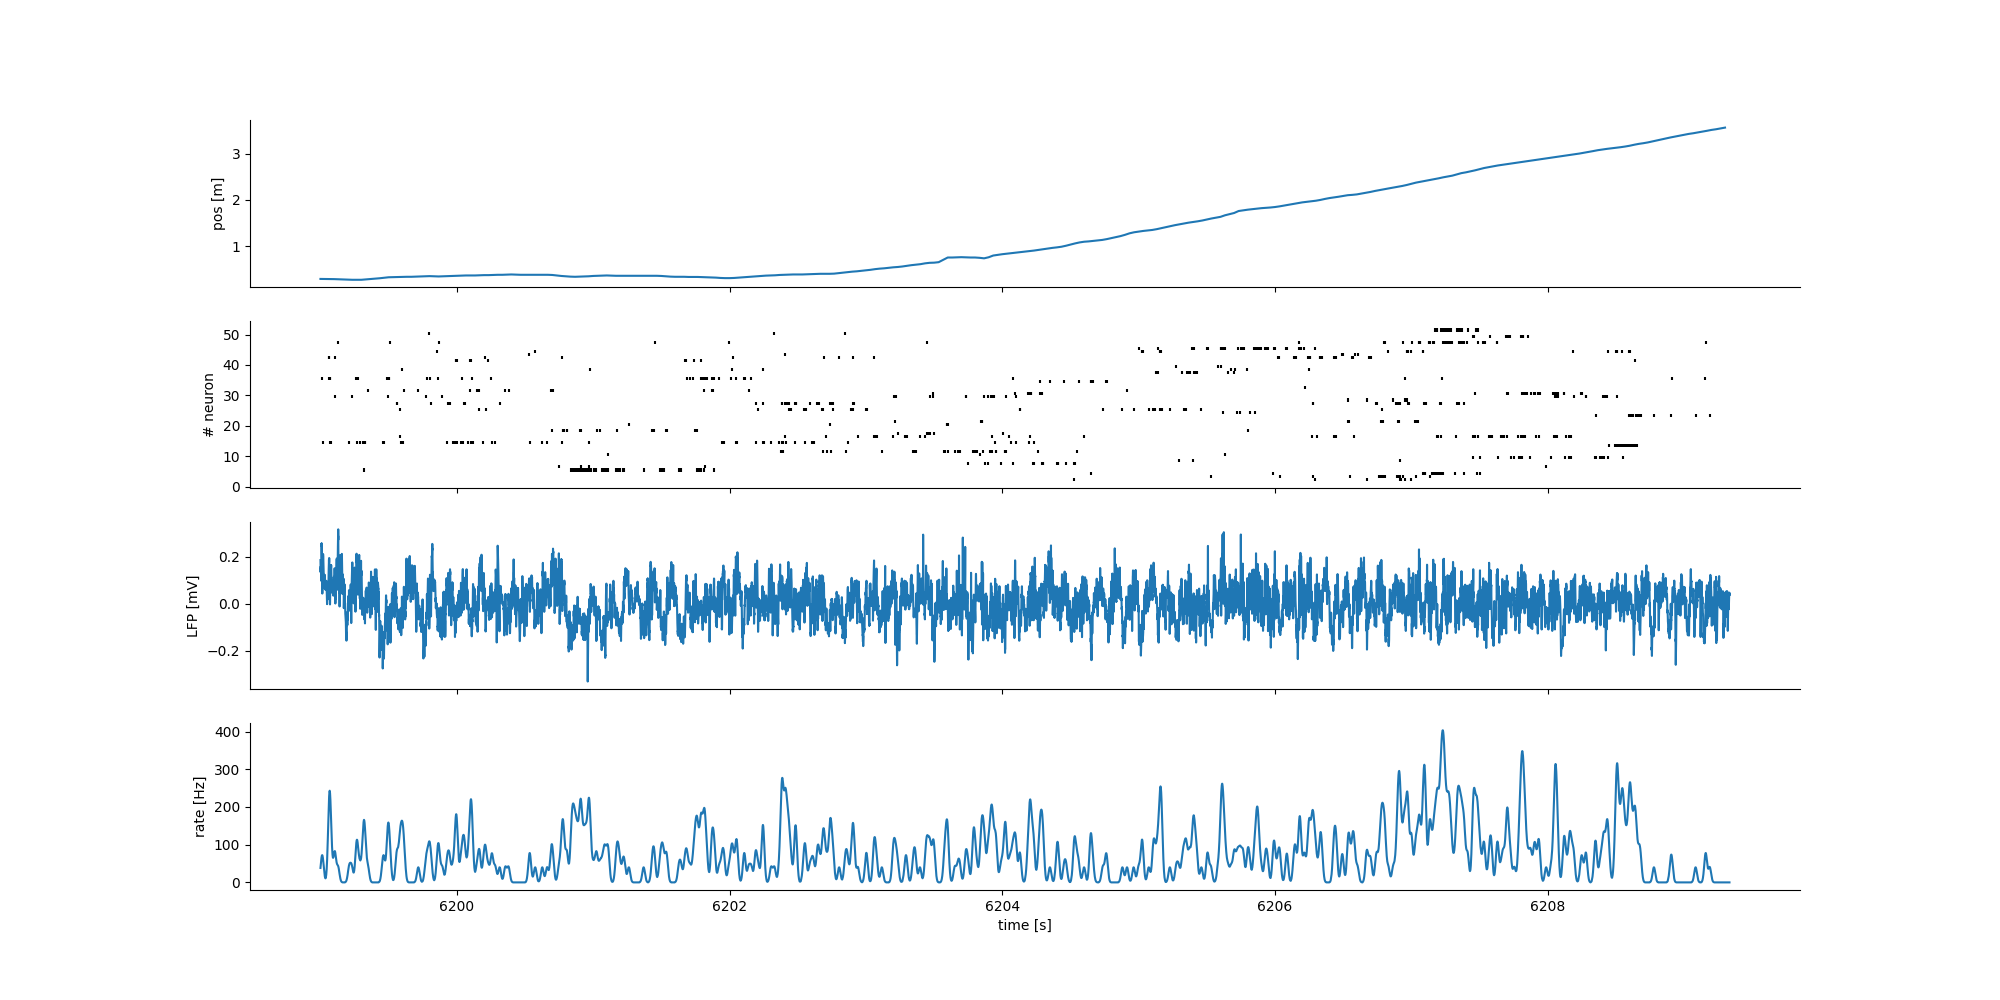

In [21]:
pos_time, pos, spikes_run = plot_raw_data(0,310, True)

In [438]:
#pos_time
#pos
#spikes_run

In [439]:
time_bin, pos_bin, spike_bin = calc_binned_data(pos_time, pos, spikes_run, binsize=0.2)

In [440]:
time_bin

array([6199. , 6199.2, 6199.4, 6199.6, 6199.8, 6200. , 6200.2, 6200.4,
       6200.6, 6200.8, 6201. , 6201.2, 6201.4, 6201.6, 6201.8, 6202. ,
       6202.2, 6202.4, 6202.6, 6202.8, 6203. , 6203.2, 6203.4, 6203.6,
       6203.8, 6204. , 6204.2, 6204.4, 6204.6, 6204.8, 6205. , 6205.2,
       6205.4, 6205.6, 6205.8, 6206. , 6206.2, 6206.4, 6206.6, 6206.8,
       6207. , 6207.2, 6207.4, 6207.6, 6207.8, 6208. , 6208.2, 6208.4,
       6208.6, 6208.8, 6209. , 6209.2])

In [309]:
pos_time[-1]

6209.3

In [300]:
time_bin

array([6199. , 6199.2, 6199.4, 6199.6, 6199.8, 6200. , 6200.2, 6200.4,
       6200.6, 6200.8, 6201. , 6201.2, 6201.4, 6201.6, 6201.8, 6202. ,
       6202.2, 6202.4, 6202.6, 6202.8, 6203. , 6203.2, 6203.4, 6203.6,
       6203.8, 6204. , 6204.2, 6204.4, 6204.6, 6204.8, 6205. , 6205.2,
       6205.4, 6205.6, 6205.8, 6206. , 6206.2, 6206.4, 6206.6, 6206.8,
       6207. , 6207.2, 6207.4, 6207.6, 6207.8, 6208. , 6208.2, 6208.4,
       6208.6, 6208.8, 6209. , 6209.2])

In [307]:
np.histogram(spikes_run[2], bins=time_bin)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 3, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0]),
 array([6199. , 6199.2, 6199.4, 6199.6, 6199.8, 6200. , 6200.2, 6200.4,
        6200.6, 6200.8, 6201. , 6201.2, 6201.4, 6201.6, 6201.8, 6202. ,
        6202.2, 6202.4, 6202.6, 6202.8, 6203. , 6203.2, 6203.4, 6203.6,
        6203.8, 6204. , 6204.2, 6204.4, 6204.6, 6204.8, 6205. , 6205.2,
        6205.4, 6205.6, 6205.8, 6206. , 6206.2, 6206.4, 6206.6, 6206.8,
        6207. , 6207.2, 6207.4, 6207.6, 6207.8, 6208. , 6208.2, 6208.4,
        6208.6, 6208.8, 6209. , 6209.2]))

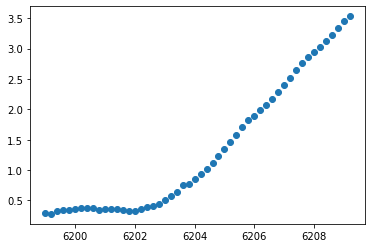

In [441]:
plt.plot(time_bin, pos_bin, 'o')

In [234]:
time_bin

array([6199. , 6199.2, 6199.4, 6199.6, 6199.8, 6200. , 6200.2, 6200.4,
       6200.6, 6200.8, 6201. , 6201.2, 6201.4, 6201.6, 6201.8, 6202. ,
       6202.2, 6202.4, 6202.6, 6202.8, 6203. , 6203.2, 6203.4, 6203.6,
       6203.8, 6204. , 6204.2, 6204.4, 6204.6, 6204.8, 6205. , 6205.2,
       6205.4, 6205.6, 6205.8, 6206. , 6206.2, 6206.4, 6206.6, 6206.8,
       6207. , 6207.2, 6207.4, 6207.6, 6207.8, 6208. , 6208.2, 6208.4,
       6208.6, 6208.8, 6209. , 6209.2])

In [235]:
np.array(pos_bin)

array([0.28614916, 0.27868067, 0.32343647, 0.34185731, 0.35078089,
       0.36582031, 0.37899921, 0.38305673, 0.37396031, 0.34412578,
       0.36155002, 0.35971943, 0.35427257, 0.33632565, 0.32072537,
       0.32436147, 0.36390817, 0.38728375, 0.40166255, 0.44290502,
       0.50640974, 0.56991443, 0.64740858, 0.75781062, 0.76881287,
       0.8539157 , 0.92745735, 1.02483393, 1.1217042 , 1.23610421,
       1.34981296, 1.46283646, 1.56895165, 1.70916692, 1.81585385,
       1.88957387, 1.9813302 , 2.07860994, 2.16683686, 2.27755868,
       2.40266434, 2.5217555 , 2.65476437, 2.76746941, 2.85447609,
       2.94074881, 3.03271345, 3.12364244, 3.22050524, 3.34076635,
       3.45373456, 3.53119183])

In [250]:
spike_bin[2]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 3, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

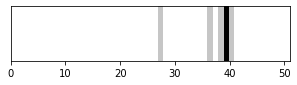

In [246]:
fig, ax = plt.subplots(1,1, figsize=(5,1))
ax.pcolormesh([spike_bin[2]], cmap='Greys')
ax.set_yticks([])
plt.show()

In [252]:
spike_bin.shape

(53, 51)

In [258]:
np.sum(spike_bin, axis=0)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

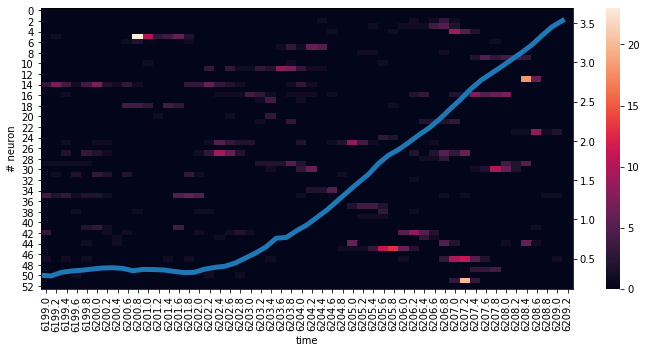

In [380]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(spike_bin, xticklabels=time_bin.round(2), ax=ax)
ax.set_xlabel('time')
ax.set_ylabel('# neuron')

ax2 = ax.twinx()
ax2.plot(pos_bin, linewidth=5)

plt.tight_layout()

In [448]:
place_fields = np.array([pos_bin[mask.astype('bool')] for mask in spike_bin != 0])
place_field_weights = np.array([sp[mask.astype('bool')] for sp, mask in zip(spike_bin, spike_bin != 0)])

## still

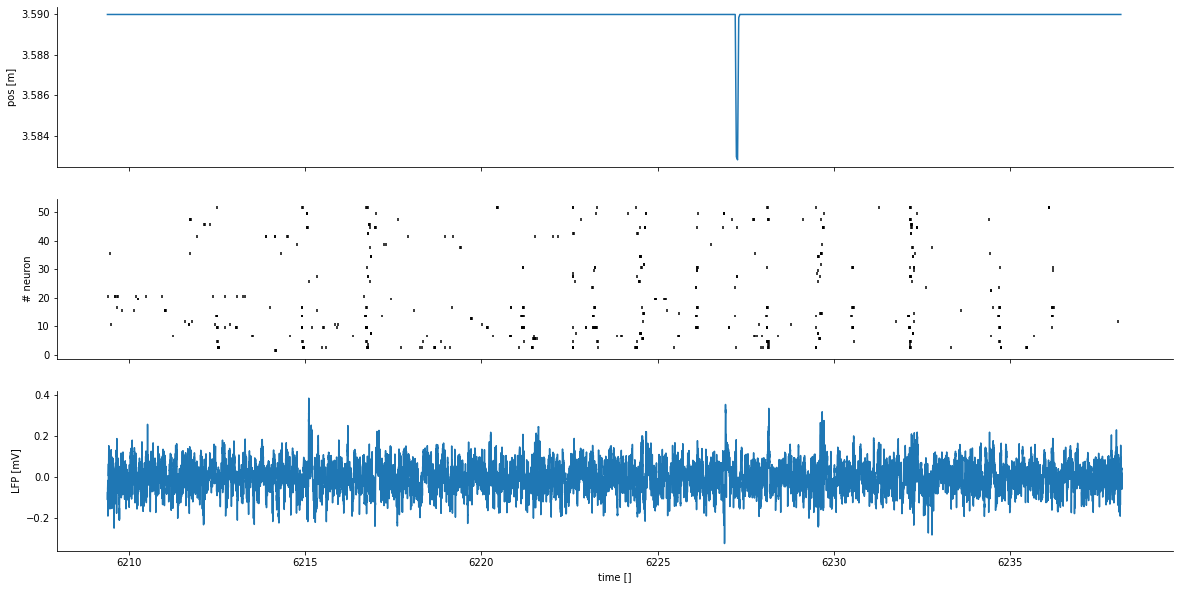

In [449]:
pos_time_s, pos_s, spikes_run_s = plot_raw_data(312,1175, True)

In [450]:
time_bin_s, pos_bin_s, spike_bin_s = calc_binned_data(pos_time_s, pos_s, spikes_run_s, binsize=0.2)

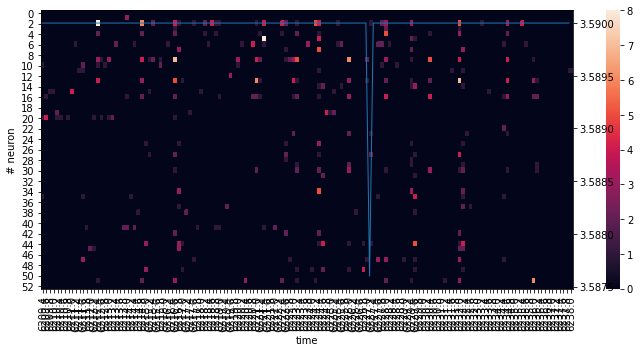

In [451]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(spike_bin_s, xticklabels=time_bin_s.round(2), ax=ax)
ax.set_xlabel('time')
ax.set_ylabel('# neuron')

ax2 = ax.twinx()
ax2.plot(pos_bin_s, linewidth=1)

plt.tight_layout()

In [475]:
mask = np.where(spike_bin_s[:,100] != 0)[0]

In [479]:
weight = spike_bin_s[:,100][mask]

In [480]:
place_fields_decoded = place_fields[mask]

In [486]:
weight

array([3, 2, 2, 1, 1, 1, 1, 1, 1, 3, 1])

In [481]:
place_fields_decoded

array([array([1.02483393, 1.9813302 , 2.16683686, 2.27755868, 2.40266434]),
       array([0.27868067, 0.34412578, 0.36155002, 0.35971943, 0.35427257,
       0.33632565, 0.32072537]),
       array([0.75781062, 0.76881287, 0.8539157 , 0.92745735, 1.02483393]),
       array([2.65476437, 2.76746941, 2.85447609, 2.94074881, 3.03271345,
       3.12364244]),
       array([3.12364244, 3.22050524]),
       array([0.28614916, 0.27868067, 0.32343647, 0.34185731, 0.35078089,
       0.36582031, 0.37899921, 0.38305673, 0.37396031, 0.34412578,
       0.32072537, 0.32436147, 0.36390817, 0.38728375, 0.40166255,
       0.44290502, 0.76881287, 0.8539157 , 0.92745735]),
       array([0.32343647, 0.36582031, 0.37899921, 0.36390817, 0.38728375,
       0.40166255, 0.44290502, 0.50640974, 0.8539157 , 1.1217042 ,
       1.23610421, 1.34981296, 1.46283646, 1.56895165, 2.16683686]),
       array([2.07860994, 2.16683686, 2.27755868]),
       array([0.28614916, 0.27868067, 0.32343647, 0.34185731, 0.35078089,
     

In [491]:
pos_decoded = [list(place)*w for place, w in zip(place_fields_decoded, weight)]

In [493]:
pos_decoded=[element for sublist in pos_decoded for element in sublist]

In [53]:
decode['dec15ms']

array([[(array([[6199.   , 6199.015, 6199.03 , ..., 7047.925, 7047.94 , 7047.955]]), array([[0.05],
               [0.15],
               [0.25],
               [0.35],
               [0.45],
               [0.55],
               [0.65],
               [0.75],
               [0.85],
               [0.95],
               [1.05],
               [1.15],
               [1.25],
               [1.35],
               [1.45],
               [1.55],
               [1.65],
               [1.75],
               [1.85],
               [1.95],
               [2.05],
               [2.15],
               [2.25],
               [2.35],
               [2.45],
               [2.55],
               [2.65],
               [2.75],
               [2.85],
               [2.95],
               [3.05],
               [3.15],
               [3.25],
               [3.35],
               [3.45],
               [3.55]]), array([[1.17481333e-01, 3.89158507e-18, 4.11420675e-02, ...,
                2.91899260e-64, 

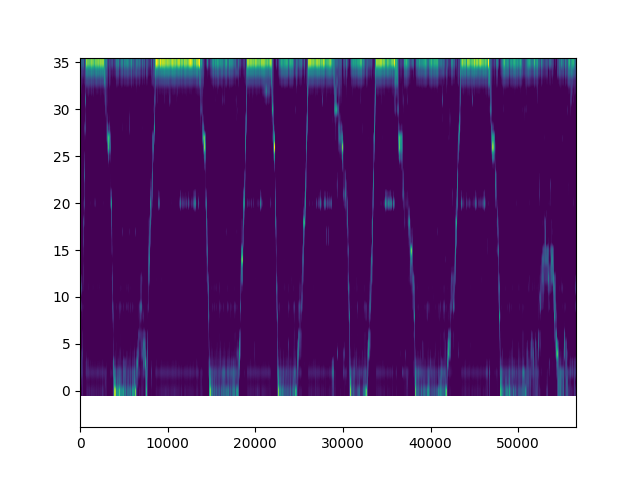

In [11]:
plt.figure()
plt.imshow(decode['dec15ms'][0][0][2], 
           aspect='auto', origin='lower',vmin=1/35, vmax=.25)
#plt.xticks(decode['dec15ms'][0][0][0][0])
for rip in decode['newRipples']:
    plt.plot(rip,[-2]*2,linewidth=2, color='r')
plt.show()